# Liquid Alpha (Consensus based weights)

This notebook accompanies the release of the consensus-based weight feature. The weight we are referring to here is the alpha term in the moving average portion of the bond calculation. See the medium post for a detailed discussion of the reasoning behind this update.

Here, we propose another approach in addition to the commitment scheme to amplify the advantage of validators that take actions earlier. In turn, this amplifies the disadvantage of validators who copy or act reactively to other validators' actions. Once this disadvantage reaches a certain threshold, it becomes preferable for TAO owners to either perform miner-evaluation work as intended or delegate their stakes to other validators who perform such work.

The rest of this notebook shows a method subnet owners can use to determine their preferred value of `alpha_low, alpha_high, commit_reveal_interval`.

Please refer to our paper or [blog post](https://blog.bittensor.com/consensus-based-weights-1c5bbb4e029b) for the description of the algorithm.

## Imports & setup

In [ ]:
netuid = 17 

In [178]:
import os 
import pickle

import torch 
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import bittensor as bt

from experiment_setup import ExperimentSetup

setups = []

for alpha_low in np.arange(0.1, 0.95, 0.1):
    for alpha_high in np.arange(0.1, 0.95, 0.1):
        if alpha_low > alpha_high:
            continue
        
        setups.append(ExperimentSetup(
            netuids = [netuid],
            start_block = 2987500, # please choose a more recent start block
            processes=1,
            result_path=f'./liquid_alpha_results/liquid_alpha_results_al{alpha_low:.2f}_ah{alpha_high:.2f}',
            liquid_alpha = True, 
            alpha_low = round(alpha_low, 2),
            alpha_high = round(alpha_high, 2),
            data_points = 60,
            conceal_period = [3, 5, 7, 9, 11]
        ))

## Download metagraphs

In [171]:
from download_metagraphs import DownloadMetagraph
DownloadMetagraph(setup = setups[0]).run()

## Run simulation

In [172]:
import torch.multiprocessing as mp
from weight_copy_simulation import WeightCopySimulation

def target(setup):
    WeightCopySimulation(setup = setup).run_simulation()

processes = [] 
for _setup in setups:
    p = mp.Process(target=target, args=(_setup,), name=f'Process-{_setup.alpha_low:.2f}-{_setup.alpha_high:.2f}') 
    p.start() 
    processes.append(p) 
      
for p in processes: 
    p.join() 

## Analysis
(1) Calculate relative dividend rate for weight copier

(2) Choose the optimal setting that gives weight copier the most discound in dividend 

(3) Check how would this setting affect the dividend of regular honest vlaidators 
 

### (1) Calculate relative dividend rate for weight copier under different setting

With $D$ as dividend; $S$ as stake; $\mathcal Z$ as the set of validators.
We use the relative dividend rate of the copier $j$,

$$G^j = \frac{D^j/S^j}{\underset{i \in \mathcal Z \setminus \{j\}}{\mathrm{median}} \{D^i/S^i\}}$$

- The lower the dividend rate (G), the more discount in dividend we are giving to the weight copier

- 360 * conceal_period = commit_reveal_weight_interval

- commit_reveal_weight_interval, alpha_low and alpha_high are the parameters made availble for the SN owner to set to the chain

In [173]:
def get_relative_dividend_rate(setup):
    div_rates = {}
    divs = {}
    yuma_results = {}

    for netuid in setup.netuids:
        div_rates[netuid] = {}
        divs[netuid] = {}
        yuma_results[netuid] = {}
        
        for conceal_period in setup.conceal_periods:
            with open(f"{setup.result_path}/yuma_result_netuid{netuid}_conceal{conceal_period}.pkl", 'rb') as handle:
                _yuma_results = pickle.load(handle)

            dividend = [
                (s["validator_reward_normalized"] / s["stake"]).tolist()
                for idx, s in _yuma_results.items()
            ]

            dividend_df = pd.DataFrame(
                dividend,
                columns=[f"v{i}" for i in range(len(dividend[0]) - 1 )] + ["v_bad"],
            )
            
            div_last = dividend_df.iloc[-1]
            if (div_last.isna()).any():
                div_rate = None
            else:
                div_rate = div_last[-1] / div_last[:-1].median() 

            divs[netuid][conceal_period] = div_last
            div_rates[netuid][conceal_period] = div_rate
            yuma_results[netuid][conceal_period] = _yuma_results

    div_rates = pd.DataFrame(div_rates, dtype='float64')
    div_rates.index = div_rates.index.map(lambda x : x)

    return div_rates, divs, yuma_results

In [174]:
min_conceal_period = None
divs = {}
div_rates = []

for _setup in setups:
    _div_rates, _divs, _yuma_results = get_relative_dividend_rate(_setup)
    for netuid in _div_rates:
        for conceal_period, div_rate in _div_rates[netuid].items():
            div_rates.append([netuid, conceal_period, _setup.alpha_low, _setup.alpha_high, div_rate, _divs[netuid][conceal_period]])
    
div_rates = pd.DataFrame(div_rates, columns = ['netuid', 'conceal_period', 'alpha_low', 'alpha_high', 'div_rate', 'dividend'])

div_rates.sort_values('div_rate')

,netuid,conceal_period,alpha_low,alpha_high,div_rate,dividend
119,17,11,0.3,0.9,0.962205,v0 1.000299 v1 1.016874 v2 1...
84,17,11,0.2,0.9,0.962268,v0 1.000610 v1 1.016862 v2 1...
149,17,11,0.4,0.9,0.962452,v0 0.999980 v1 1.016922 v2 1...
44,17,11,0.1,0.9,0.962585,v0 1.000948 v1 1.016914 v2 1...
174,17,11,0.5,0.9,0.963123,v0 0.999634 v1 1.016991 v2 1...
...,...,...,...,...,...,...
170,17,3,0.5,0.9,1.000489,v0 0.993665 v1 1.014831 v2 1...
190,17,3,0.6,0.9,1.000821,v0 0.993612 v1 1.014849 v2 1...
205,17,3,0.7,0.9,1.001216,v0 0.993529 v1 1.014843 v2 1...
215,17,3,0.8,0.9,1.001720,v0 0.993465 v1 1.014772 v2 1...


### (2) Choose the optimal setting that gives weight copier the most discound in dividend

- The lower the relative dividend rate (G), the more discount in dividend we are giving to the weight copier


- commit_reveal_weight_interval = 360 * conceal_period


- For the conceal period to be effective, you should set a conceal period large enough to produce enough lost in dividend for the weight copier.

| Dividend gain (G) | Effect                                                                                                     |
|------------------|------------------------------------------------------------------------------------------------------------|
| < 1               | Norminator lost the incentive to delegate to weight copier, weight copier earn less validator take.  |
| < 0.82          | Weigh copier lost the incentive to copy weight.                                                      |

- If given a conceal period long enough (>15 hours) and the SN still fail to produce enough lost in dividend, it means that there is not enough churn and weight movement in the SN, so the existing weight copiy fix may not work for your SN. Depending on the situation, you may choose to increase competitiveness/ churn in your SN or just leave the weight copier as is. Cause when there is no churn in the SN, there would be no movement in consensus as well, so the weight copier would not be as beneficial. 

- Note that when the conceal period was set too long, it would slow down the discovery of new miners, putting them at risk for deregistration. Further more, it would means that any change in the network would only be observable after 360 * conceal_period blocks. 

Text(0.5, 0.98, 'First mover advantage under different conditions')

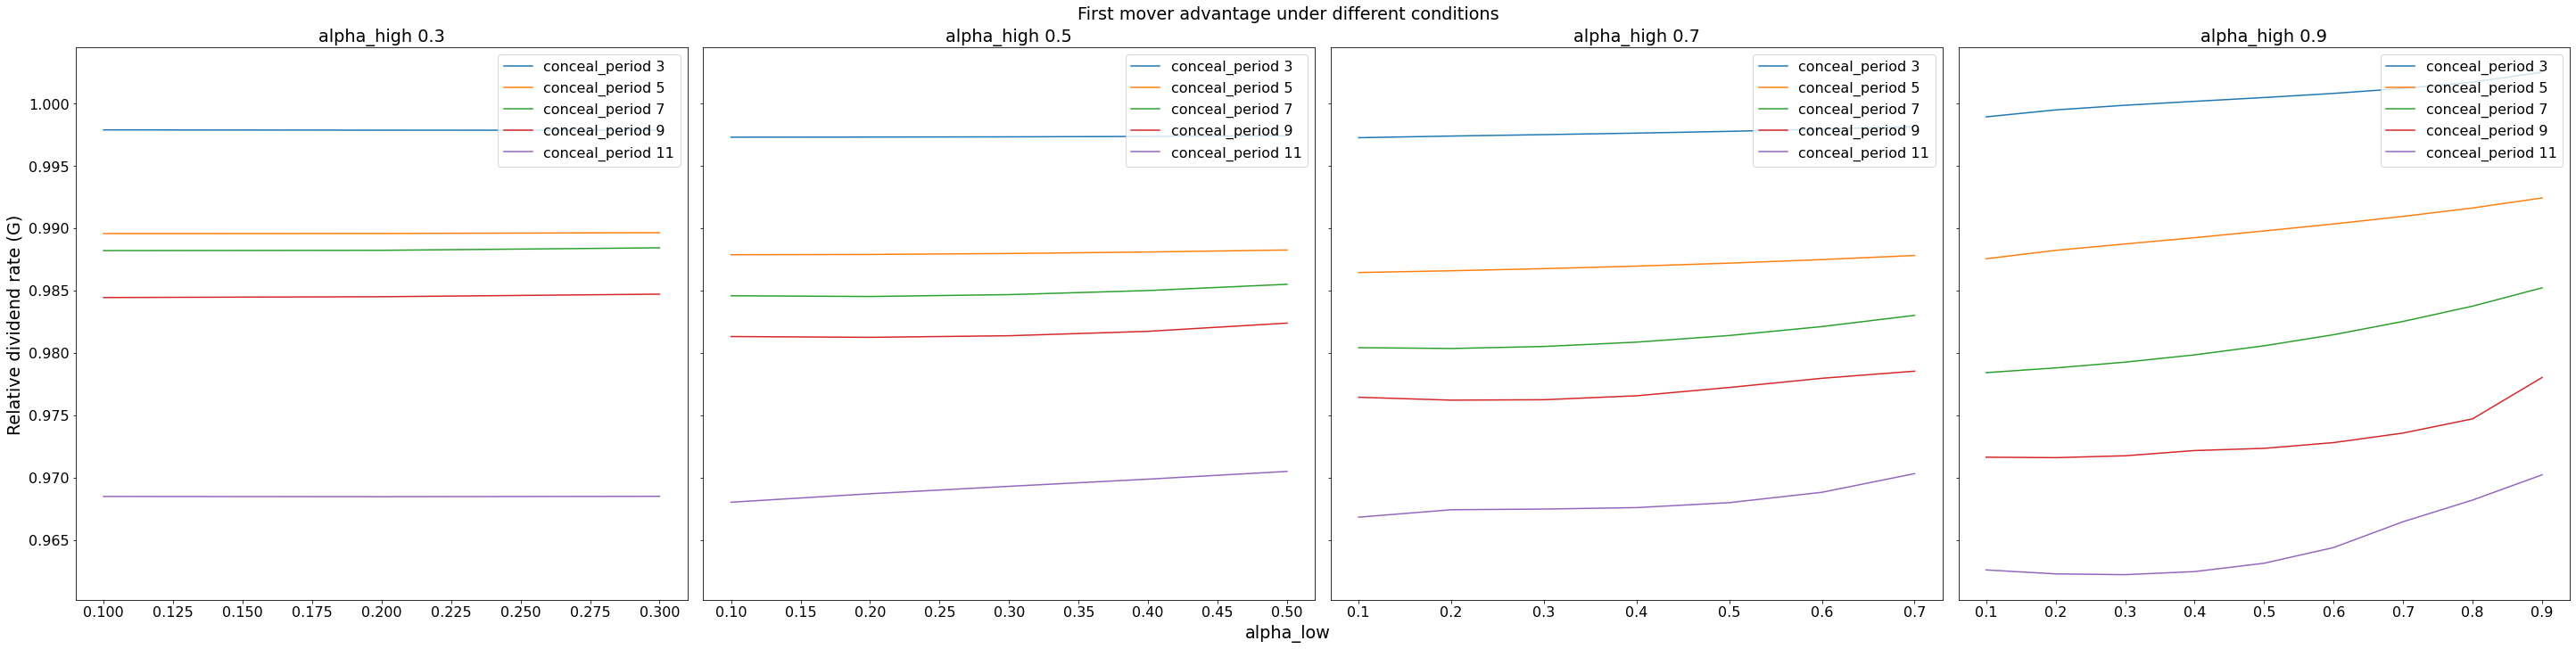

In [176]:
plt.rcParams.update({'font.size': 16})

cols = 4
fig, axes = plt.subplots(1, cols, sharey=True, figsize=(40, 10), layout='constrained')

for idx, alpha_high in enumerate(np.arange(0.3, 0.95, 0.2)):
    df = div_rates[div_rates.alpha_high == round(alpha_high, 2)]
    
    ax = axes[idx%cols]
    ax.set_title(f"alpha_high {round(alpha_high, 2)}")
    for conceal_period in df['conceal_period'].unique():
        _df = df[df.conceal_period == conceal_period]
        ax.plot(
            _df['alpha_low'],
            _df['div_rate'],
            label = f"conceal_period {conceal_period}",
        )
    ax.legend(loc="upper right")

fig.supylabel('Relative dividend rate (G)')
fig.supxlabel('alpha_low')
fig.suptitle("Change in Relative dividend rate (G) under different conditions")

### (3) Check ther performance with the selected parameter and how would the setting affects the dividend of honest vlaidators 

Please set the parameters below 

In [117]:
conceal_period = 11
alpha_high = 0.9
alpha_low = 0.2

#### Where would weight copier be positioned compared to honest validator in terms of dividend

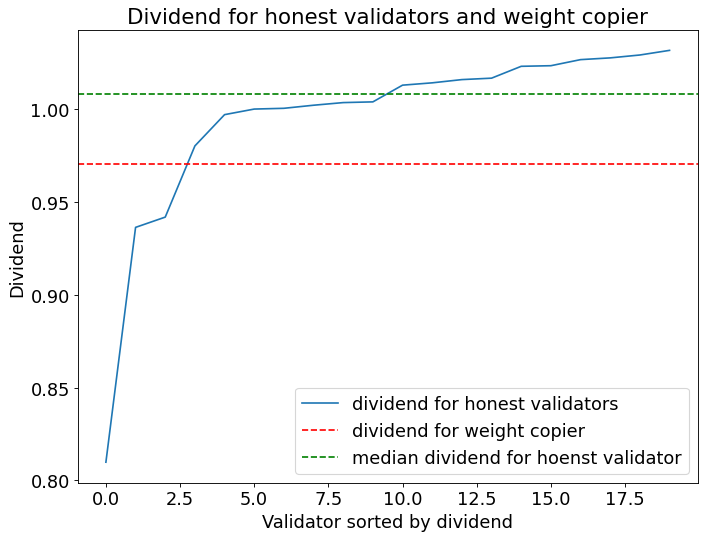

In [159]:
df = div_rates[(div_rates.conceal_period == conceal_period) & (div_rates.alpha_high == alpha_high) & (div_rates.alpha_low == alpha_low) ]
la_dividend_df = pd.DataFrame(list(df.dividend.values)).T

figure(figsize=(10, 7.5), dpi=80)

plt.plot(la_dividend_df.iloc[:-1, 0].sort_values().reset_index(drop = True), label = 'dividend for honest validators')
plt.axhline(y = la_dividend_df.iloc[-1].values, color = 'r', linestyle = '--', label = 'dividend for weight copier') 
plt.axhline(y = la_dividend_df.iloc[:-1, 0].median(), color = 'green', linestyle = '--', label = 'median dividend for hoenst validators') 

plt.title("Dividend for honest validators and weight copier")
plt.ylabel("Dividend per stake")
plt.xlabel("Validator sorted by dividend")
plt.legend()

#### How would the dividend of honest validator change with or without liquid alpha

- The goal here is to make sure any parameter we are choosing here would not decrease the dividend that honest peers are receiving. 

- Note that when alpha_low = alpha_high = 0.9, it is equivalent to when liquid alpha is disabled

- We can consider a success when most of the scatters are at or above the line x = y

Text(0, 0.5, 'Dividend to honest validator with liquid alpha\nalpha_low = 0.2, alpha_high = 0.9')

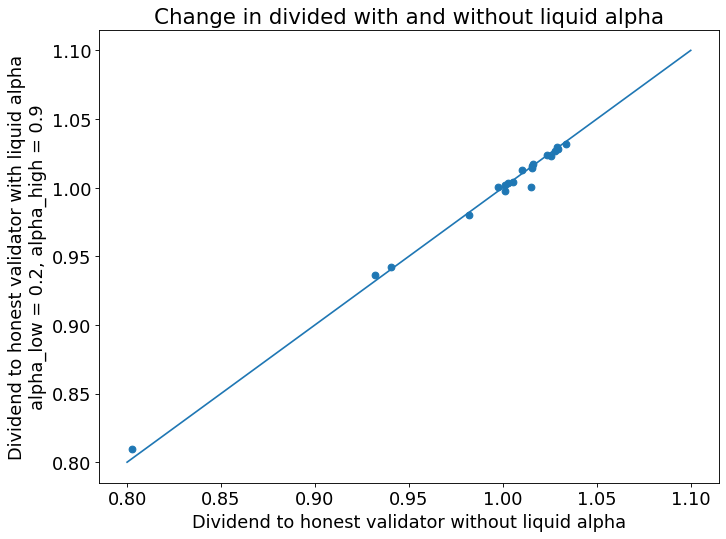

In [169]:
df = div_rates[(div_rates.conceal_period == conceal_period) & (div_rates.alpha_high == 0.9) & (div_rates.alpha_low == 0.9) ]
dividend_df = pd.DataFrame(list(df.dividend.values)).T

figure(figsize=(10, 7.5), dpi=80)
plt.scatter(dividend_df.iloc[:-1, 0], la_dividend_df.iloc[:-1, 0])
plt.plot([0.8, 1.1], [0.8, 1.1])
plt.title('Change in divided with and without liquid alpha')
plt.xlabel('Dividend to honest validator without liquid alpha')
plt.ylabel(f'Dividend to honest validator with liquid alpha\nalpha_low = {alpha_low}, alpha_high = {alpha_high}')